In [52]:
!pip install skops

from skops.io import dump

# sklearn Setup
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, accuracy_score, mean_squared_error
from sklearn.linear_model import RidgeCV, Ridge, LassoCV, Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# Pandas Setup
import json
import glob
import pandas as pd
import numpy as np
import datetime as dt
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from matplotlib import dates as mdates
from matplotlib.lines import Line2D

In [44]:
df = pd.read_csv("synthetic_data.csv")
label = df['reputation_score']
features = df.drop(columns=['reputation_score'])

In [45]:
x_train_rf, x_test_rf, y_train_rf, y_test_rf = train_test_split(features, label, test_size = 0.2, random_state = 1900)

In [46]:
scaler = StandardScaler()
x_train_sc_rf = scaler.fit_transform(x_train_rf)
x_test_sc_rf = scaler.transform(x_test_rf)
pca = PCA(n_components = x_train_sc_rf.shape[1])
pca_x_train_rf = pca.fit_transform(x_train_sc_rf)

[0.63510604 0.75629554 0.84218659 0.91280455 0.95536315 0.97861777
 0.9952868  1.        ]


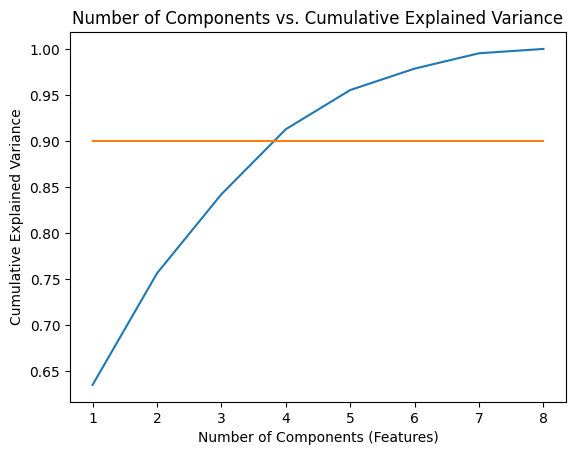


We first surpass 90% explained variance with 4 components.


In [47]:
cum_expl_var_ratios_rf = np.cumsum(pca.explained_variance_ratio_)
print(cum_expl_var_ratios_rf)

plt.plot(np.arange(1, 9), cum_expl_var_ratios_rf)
plt.plot(np.arange(1, 9), [0.90]*8)
plt.xlabel("Number of Components (Features)")
plt.ylabel("Cumulative Explained Variance")
plt.title("Number of Components vs. Cumulative Explained Variance")
plt.show()

print("")

for i in range(len(cum_expl_var_ratios_rf)):
  if cum_expl_var_ratios_rf[i] >= 0.90:
    print("We first surpass 90% explained variance with " + str(i + 1) + " components.")
    break

In [48]:
ideal_pca_rf = PCA(n_components = 4)
ideal_pca_rf.fit_transform(x_train_sc_rf)

# The x train/test set with only the ideal 5 components
ideal_pca_x_train_sc_rf = ideal_pca_rf.transform(x_train_sc_rf)
ideal_pca_x_test_sc_rf = ideal_pca_rf.transform(x_test_sc_rf)

In [49]:
rf_classifier = RandomForestClassifier(n_estimators = 3, max_depth = 2)
rf_classifier.fit(ideal_pca_x_train_sc_rf, y_train_rf)
rf_preds = rf_classifier.predict(ideal_pca_x_test_sc_rf)
rf_accuracy = metrics.accuracy_score(y_test_rf, rf_preds)

print("Our Random Forest Binary Classifier predicts with " + str(round(rf_accuracy * 100, 2)) + "% accuracy")

Our Random Forest Binary Classifier predicts with 22.0% accuracy


In [50]:
combos_dict = {}

n_est_lst = []
m_depth_lst = []
acc_lst = []

for n_est in range(1, 200, 10):
  for m_depth in range(1, 6, 2):
    rf_classifier = RandomForestClassifier(n_estimators = n_est, max_depth = m_depth)
    rf_classifier.fit(ideal_pca_x_train_sc_rf, y_train_rf)
    rf_preds = rf_classifier.predict(ideal_pca_x_test_sc_rf)
    rf_accuracy = metrics.accuracy_score(y_test_rf, rf_preds)
    combos_dict[(n_est, m_depth)] = rf_accuracy
    n_est_lst.append(n_est)
    m_depth_lst.append(m_depth)
    acc_lst.append(rf_accuracy)

best_combo = None
max_acc = 0

for combo in combos_dict.keys():
  if combos_dict[combo] > max_acc:
    best_combo = combo
    max_acc = combos_dict[combo]

print("We get the highest testing accuracy (" + str(round(max_acc * 100, 2)) + "%) with " + str(best_combo[0]) + " trees and with a max depth of " + str(best_combo[1]))

We get the highest testing accuracy (22.6%) with 71 trees and with a max depth of 1


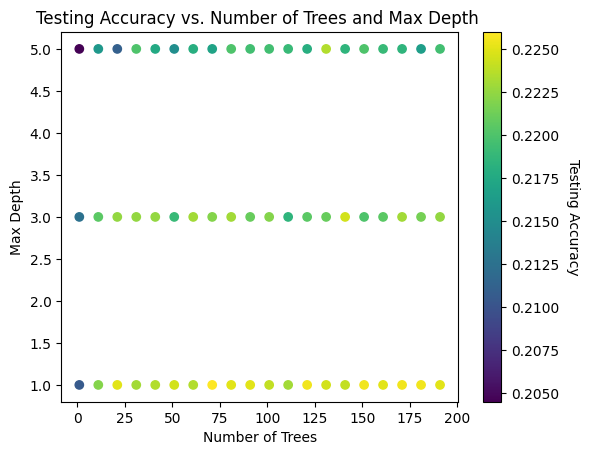

In [51]:
fig, ax = plt.subplots();
d_points = ax.scatter(n_est_lst, m_depth_lst, c = acc_lst, cmap = sns.color_palette("viridis", as_cmap = True));
cbar = fig.colorbar(d_points);
ax.set_xlabel("Number of Trees");
ax.set_ylabel("Max Depth");
ax.set_title("Testing Accuracy vs. Number of Trees and Max Depth ");
cbar.set_label("Testing Accuracy", rotation = 270, labelpad = 15);

In [53]:
# check with sklearn built-in functionality

# Create the parameter grid based on the results of random search
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2)

In [57]:
grid_search.fit(x_train_rf, y_train_rf)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110],
                         'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 200, 300, 1000]},
             verbose=2)

In [58]:
grid_search.best_params_
best_grid = grid_search.best_estimator_
rf_preds = best_grid.predict(x_test_rf)
grid_accuracy = metrics.accuracy_score(y_test_rf, rf_preds)

print("We get the highest testing accuracy")

We get the highest testing accuracy


In [60]:
print(f"We get the highest testing accuracy at {grid_accuracy}")

We get the highest testing accuracy at 0.225
